In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[2]:


import rebound, numpy as np, matplotlib as mpl
#mpl.use('Agg') # found here:https://stackoverflow.com/questions/4931376/generating-matplotlib-graphs-without-a-running-x-server
import matplotlib.pyplot as plt, time as tiempo, math, sys

sim = rebound.Simulation()
tau = 2*np.pi


# In[3]:


def ttor(R0 = 5e-4): #two to one resonance
    sim = rebound.Simulation()
    #sim.units = ('yr', 'AU', 'Msun') #sets G=4pi^2 so AU, earth years, solar masses
    #R0 = 5**(1/3)*0.01
    sim.add(m=1) #creates a star of mass 1
    sim.add(m=1e-3, a=1, r=R0)  #creates a planet with mass 0.001 at 1 AU
    sim.add(m=1e-3, a=2**(2/3), f=np.pi, r=R0) 
    return sim

def tttr(R0 = 5e-4): #two to three resonance
    sim = rebound.Simulation()
    #sim.units = ('yr', 'AU', 'Msun') #sets G=4pi^2 so AU, earth years, solar masses
    #R0 = 0.01
    sim.add(m=1) #creates a star of mass 1
    sim.add(m=1e-3, a=2**(2/3), r=R0)  #creates a planet with mass 0.001 at 1 AU
    sim.add(m=1e-3, a=3**(2/3), f=np.pi, r=R0) 
    return sim

def nor(R0 = 5e-4): #no resonance (initially at least)
    sim = rebound.Simulation()
    #sim.units = ('yr', 'AU', 'Msun') #sets G=4pi^2 so AU, earth years, solar masses
    sim.add(m=1) #creates a star of mass 1
    #R0 = .02
    sim.add(m=1e-3, a=1, r=R0)  #creates a planet with mass 0.001 at 1 AU
    sim.add(m=1e-3, a=1.8, f=np.pi, r=R0) #use .1 mass to show the planets having a large effect on each other
    return sim
    
def resonance_counter(data, base = 1):
    innerplanetcount = 0
    outerplanetcount = 0
    for i, x in enumerate(np.delete(data,len(data)-1,0)):
        if x[0] < 0 and data[i+1][0] > 0:
            innerplanetcount += 1
        if x[1] < 0 and data[i+1][1] > 0:
            outerplanetcount += 1
    R = innerplanetcount/outerplanetcount
    print(R)
    R = R*base
    if R == int(R):
        R = int(R)
    print("The outer planet revolved", outerplanetcount, "times.")
    print("The inner planet revolved", innerplanetcount, "times.")
    print("They are in a {}:{} resonance.".format(base, R))
     
def rand_powerlaw(slope, min_v, max_v): #some distribution functions
    #https://rebound.readthedocs.io/en/latest/ipython/PrimordialEarth.html
    y = np.random.uniform()
    pow_max = pow(max_v, slope+1.)
    pow_min = pow(min_v, slope+1.)
    return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))
def rand_uniform(minimum, maximum):
    return np.random.uniform()*(maximum-minimum)+minimum
def rand_rayleigh(sigma):
    return sigma*np.sqrt(-2*np.log(np.random.uniform()))

def quickplot(sim): #this uses matplotlib to plot the orbit, instead of rebound
    coords = np.zeros((2,sim.N))
    for i in range(sim.N):
        coords[0][i], coords[1][i] = sim.particles[i].x, sim.particles[i].y
    fig, ax = plt.subplots()
    ax.axis('equal')
    ax.scatter(coords[0],coords[1],marker=".",linewidth=0)
    for i in range(sim.N_active):
        ax.scatter(sim.particles[i].x,sim.particles[i].y); # Planet
        
def my_merge(sim_pointer, collided_particles_index):
    
    #https://rebound.readthedocs.io/en/latest/ipython/User_Defined_Collision_Resolve.html
    #or
    #https://rebound.readthedocs.io/en/latest/ipython_examples/User_Defined_Collision_Resolve/
    
    sim = sim_pointer.contents # retreive the standard simulation object
    ps = sim.particles # easy access to list of particles

    i1 = collided_particles_index.p1   # Note that p1 < p2 is not guaranteed.
    j1 = collided_particles_index.p2
    
    if ps[i1]==0 and ps[j1]==0:
        print("both are asteroids")
        return 0
    else:
        if ps[i1].m==0: #assigns k as the planet with mass and l as the particle w/o mass
            k=j1
            l=i1
            destroyi1=True
        if ps[j1].m==0: #assigns k as the planet with mass and l as the particle w/o mass
            k=i1
            l=j1
            destroyi1=False
            
        '''fig, ax = rebound.OrbitPlot(sim, xlim = (-1.3, 1.3), ylim = (-1.3, 1.3), color=['blue', 'green'])
        ax.set_title("Merging particle {} into {}".format(j, i))
        ax.text(ps[k].x, ps[k].y, "1");
        ax.text(ps[l].x, ps[l].y, "2")'''
        # So we plot the scenario exactly at the timestep that the collision function is triggered
        
        #print("merging particle", k,'into particle', l) #use this to know when collisions occur
        
        #particle_mass = Mtot_disk/N_pl
        particle_mass=1e-5
        particle_radius = 1e-5
        # Merging Logic
        total_mass = ps[k].m + particle_mass
        #merged_planet = (ps[i] * ps[i].m + ps[j] * ps[j].m)/total_mass # conservation of momentum

        # merged radius assuming a uniform density
        merged_radius = (ps[k].r**3 + particle_radius**3)**(1/3)

        #ps[k] = merged_planet   # update p1's state vector (mass and radius will need corrections)
        ps[k].m = total_mass    # update to total mass
        ps[k].r = merged_radius # update to joined radius
        
        #sim.ri_whfast.recalculate_coordinates_this_timestep = 1 #after adding mass
        #to a particle, we must recalculate Jacobi coordinates in order to recieve
        #physical values. Note that this code should be commented out if safemode is on.
        
        if destroyi1:
            return 1 #destroys p1, which is the particle w/o mass
        else:
            return 2 #destroys p2, which is the particle w/o mass
     
    
def masslist_txt(masslist,filepath,sim = None, write_type = 'a'):
    """
    Saves the masslists into a formatted txt file.
    """
    
    def avg(lst):
        sum = 0
        for i in lst:
            sum += i
        return sum / len(lst)

    masslistcopy = masslist.copy() # Don't want to edit the original data
    percentlist = list()
    message = ''
    message+="Inner planet mass\tOuter planet mass\tPercent Difference\tSeed\n"
    for data in masslistcopy[1:]:
        data = data.copy() #comment out this line to not have the original list change
        percentdif = abs((data[0]-data[1])/data[0])*100
        roundedpercentdif = round(percentdif,2)
        percentlist.append(percentdif)
        data.insert(2,percentdif)
        for j in data:
            message += str(j)
            message +='\t'
        message +='\n'   
    message+= "\nAverage percent difference= {}.\n\n".format(avg(percentlist))
    with open(filepath,write_type) as file:
        file.write(sim+'\n')
        file.write(message)

def masslist_txt_append(masslist, filepath,sim = None,write_type = 'a', **kwargs):
    """
    Saves the masslists into a formatted txt file. This is similar to masslist_txt except 
    it lends itself better to appending. It is meant for simulations ran entirely separately.
    """
    
    def avg(listt):
        sum = 0
        for i in listt:
            sum += i
        return sum / len(listt)
    
    masslistcopy = masslist.copy() # Don't want to edit the original data
    message = ''
    import os.path
    if kwargs.get('first') or not os.path.isfile(filepath): # If file does not exist, create it. If sys.argv[1]==0,
                                                            #then will also create.
        write_type = "w"
        message += sim+'\n'
        message+="Inner planet mass\tOuter planet mass\tPercent Difference\tSeed\n"
    for data in masslistcopy[1:]:
        #data = data.copy() #comment out this line to not have the original list change
        percentdif = abs((data[0]-data[1])/data[0])*100
        roundedpercentdif = round(percentdif,2)
        data.insert(2,percentdif)
        for j in data:
            message += str(j)
            message +='\t'
        message +='\n'
    with open(filepath,write_type) as file:
        file.write(message)
    if kwargs.get('last') and len(masslist_read(filepath))/4 >= kwargs.get("lastN"):
        with open(filepath, "a") as file:
            file.write("\nAverage percent difference: {}"
                       .format(averagePercent(filepath)))
            file.write("\n"+"#"*40)
# In
def masslist_read(filePath):
    """
    Inverse of masslist_txt()
    """
    with open(filePath,'r') as datafile:
        contents = datafile.read()
    contents = contents.split()
    finalList = []
    for index,value in enumerate(contents):
        try:
            value = float(value)
            finalList.append(value)
            ####contents[index] = value
        except:
            pass
    ####for i in range(0,int(len(contents)), 4):
        ####finalList.append([contents[i:i+4]])
    return finalList
#masslist_read('test.txt')

def avg(listt, **kwargs):
    sum = 0
    length = len(listt)
    if kwargs.get('positive'):
        for i in listt:
            if i > 0:
                sum += i
            else:
                length -= 1
        return sum / length
    if kwargs.get('nonNegative'):
        for i in listt:
            if i >= 0:
                sum += i
            else:
                length -= 1
        return sum / len(listt)
    for i in listt:
        sum += i
    return sum / len(listt)

def averagePercent(filePath):
    dataList = masslist_read(filePath)
    percentList = []
    for i in range(2,len(dataList),4):
        percentList.append(dataList[i])
    return avg(percentList)

# In[4]:

def saveFigs(addOn = "", seed = 0, **kwargs):
    """
    This saves several types of graphs into a folder corresponsing to the seed.
    Optional ability to add on to the name of a file easily.
    NOTE: Depending on the stepnumber, some of these graphs may contain useless data,
    because for some data types the stepnumber needs to be very high.
    """
    if kwargs.get("test"):
        seed = "Tests"
    
    plt.clf() # clears any graphs
    quickplot(sim)
    plt.savefig("Figures/"+str(seed)+"/quickplot"+addOn+".pdf")
    
    plt.clf()
    rebound.OrbitPlot(sim,slices=0.3,color=True)
    plt.savefig("Figures/"+str(seed)+"/reboundPlot"+addOn+".pdf")
    
    plt.clf()
    rebound.OrbitPlot(sim, slices = .3, color = True, lw = 1, plotparticles = [1,2])
    plt.savefig("Figures/"+str(seed)+"/reboundPlotOnlyPlanets"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, eccs)
    plt.title('Eccentricity Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Eccentricity')
    plt.savefig("Figures/"+str(seed)+"/Eccentricity"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, relative_x_value)
    plt.title('X Value From Star Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('X Value (AU)')
    plt.savefig("Figures/"+str(seed)+"/relativeXValue"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, masses)
    plt.title('Mass of Planets Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Mass (Solar Masses)')
    plt.savefig("Figures/"+str(seed)+"/masses"+addOn+".pdf")
    
    plt.clf()
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Planet Positions')
    axs[0].plot(list(position1[:,0]), list(position1[:,1]),'o')
    axs[1].plot(list(position2[:,0]), list(position2[:,1]),'o')
    axs[0].set_aspect('equal')
    axs[1].set_aspect('equal')
    plt.savefig("Figures/"+str(seed)+"/scatterPlotPositions"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, interplanetdistance)
    plt.title('Interplanetary Distance Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Distance (AU)')
    plt.savefig("Figures/"+str(seed)+"/interplanetaryDistance"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, particleNumber)
    plt.title('sim.N over time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('sim.N (AU)')
    plt.savefig("Figures/"+str(seed)+"/particleNumber"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, asteroidEccs[:,[i for i in range(0,simNi-2-1,10)]], linewidth=1)
    plt.title('Asteroid Eccentricity Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Eccs')
    plt.savefig("Figures/"+str(seed)+"/RoidEccs"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, [avg(EccsList, nonNegative = True) for EccsList in asteroidEccs],linewidth=1)
    plt.title('Asteroid Eccentricity AVERAGE Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Eccentricity')
    plt.savefig("Figures/"+str(seed)+"/RoidEccsAverage"+addOn+".pdf")
    
    plt.clf()
    num_bins = 30
    plt.hist([data for data in asteroidEccs[-1] if data >= 0], num_bins)
    plt.title("Asteroids Final Eccentricity Histogram")
    plt.savefig("Figures/"+str(seed)+"/RoidEccsHistoEnd"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, asteroidAU[:,[i for i in range(0,simNi-2-1,10)]], linewidth=1)
    # Does not plot every asteroid
    plt.title('Asteroid Semi Major Axis Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Semi Major Axis (AU)')
    plt.ylim(bottom=-.3, top = 5) # Only want to graph part of escaping asteroids
    plt.savefig("Figures/"+str(seed)+"/RoidSMAxis"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, [avg(asteroidAUList,positive=True) for asteroidAUList in asteroidAU],linewidth=1)
    plt.title('Asteroid Semi Major Axis AVERAGE Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Semi Major Axis (AU)')
    plt.savefig("Figures/"+str(seed)+"/RoidSMAxisAverage"+addOn+".pdf")
    
    plt.clf()
    num_bins =30
    plt.hist([data for data in asteroidAU[0] if data > 0 and data < 5], num_bins)
    plt.title("Asteroids Beginning Semi Major Axis Histogram")
    plt.savefig("Figures/"+str(seed)+"/RoidSMAxisHistoStart"+addOn+".pdf")
    
    plt.clf()
    plt.hist([data for data in asteroidAU[-1] if data > 0 and data < 5], num_bins)
    plt.title("Asteroids Ending Semi Major Axis Histogram")
    plt.savefig("Figures/"+str(seed)+"/RoidSMAxisHistoEnd"+addOn+".pdf")
    
###########################################################################################

def generatettor(simulation = ttor,seed = None, asteroidnumber = 1000):  
    sim = simulation()
    sim.N_active = sim.N

    sim.integrator = "ias15"
    #sim.integrator = "whfast"
    #sim.ri_whfast.corrector = 0 #zero order corrector for better speed
    #sim.ri_whfast.safe_mode = 0 #turns off safemode, *substantial* speed boost
    #sim.dt = 0.001*2*np.pi #mutiple by 2pi if in units such that G=1
    sim.testparticle_type = 0
    #sim.ri_ias15.min_dt = 1e-6 # ensure that close encounters do not stall the integration

    #collision and boundary options
    sim.collision = "direct"
    sim.collision_resolve = my_merge
    sim.collision_resolve_keep_sorted = 1
    sim.boundary = "open"
    boxsize = 100
    sim.configure_box(boxsize)
    sim.track_energy_offset = 1

    N_pl = asteroidnumber                # Number of planetesimals
    Mtot_disk = 10*sim.particles[1].m    # Total mass of planetesimal disk
    m_pl = 0 #Mtot_disk / float(N_pl)    # Mass of each planetesimal
    r_pl = 2e-9 

    #seed = 0
    #46 is my most frequently used seed
    np.random.seed(seed) # by setting a seed we will reproduce the same simulation every time
    while sim.N < (N_pl + sim.N_active):
        #a = rand_powerlaw(0, 0.1, 3) 
        a = rand_uniform(.6,2.9)
        #e = rand_rayleigh(0.01) by default is 0
        e=0
        #inc = rand_rayleigh(0.005)
        inc=0
        f = rand_uniform(-np.pi,np.pi)
        p = rebound.Particle(simulation=sim,primary=sim.particles[0], r=r_pl, a=a, e=e, inc=inc, Omega=0, omega=0, f=f)
        # Only add planetesimal if it's far away from the planet
        d1 = np.linalg.norm(np.array(p.xyz)-np.array(sim.particles[1].xyz))
        d2 = np.linalg.norm(np.array(p.xyz)-np.array(sim.particles[2].xyz))
        d = min(d1,d2)
        if d>5e-4:
            sim.add(p)

    # Hash Creation
    ps = sim.particles
    ps[0].hash = "star"
    ps[1].hash = "innerPlanet"
    ps[2].hash = "outerPlanet"
    for i in range(3,sim.N): # this sets their hash to their starting particle number
        ps[i].hash = str(i)

    sim.collision_resolve = my_merge

    #sim.move_to_com()
    global E0
    E0 = sim.calculate_energy()
    #quickplot(sim)
    return sim
    
def quickcollect2(n, Ti, Tf, stepnumber, **kwargs): #collects orbital data on the first two bodies in a system
    initialtime = tiempo.monotonic()
#     n=2 #number of planets
#     T=80*2*np.pi #years of simulation
    # Planet variables
    global times, dist, relative_x_value,relative_y_value, eccs, position1, position2, \
    interplanetdistance, masses, particleNumber
    times = np.linspace(Ti,Tf,stepnumber)
    #diftimes = list()
    dist = np.zeros((len(times),n)) 
    relative_x_value = np.zeros((len(times),n))
    relative_y_value = np.zeros((len(times),n))
    eccs = np.zeros((len(times),n))
    position1 = np.zeros((len(times),2))
    position2 = np.zeros((len(times),2))
    interplanetdistance = np.zeros((len(times),1))
    particleNumber = np.zeros((len(times),1))
    masses = np.zeros((len(times),n))
    ps = sim.particles
    # Asteroid variables:
    global asteroidAU, asteroidEccs, simNi
    simNi = sim.N
    asteroidAU = np.zeros((len(times),simNi-n-1)) # n is the number of planets, 1 is the number of stars
    asteroidEccs = np.negative(np.ones((len(times),simNi-n-1)))
    #
    print(f"Total steps: {stepnumber}")
    print("| {} time = {} years | {} particles | {} step number |\n| {} second | {} minutes.\n"\
    .format(0,0/tau,sim.N,0,round((tiempo.monotonic()-initialtime),1)\
    ,round((tiempo.monotonic()-initialtime)/60,1)))
    #
    for i, t in enumerate(times):
        sim.integrate(t)
        print("| {} time = {} years | {} particles | {} step number |\n\
| {} second | {} minutes.\n"\
        .format(t,t/tau,sim.N,i,round((tiempo.monotonic()-initialtime),1)\
        ,round((tiempo.monotonic()-initialtime)/60,1)))
        #sim.ri_whfast.recalculate_coordinates_this_timestep = 1
        #sim.integrator_synchronize()
        #diftimes.append(sim.t+dT)
        #if i== int(stepnumber/2):
            #print("1/2 done at {} seconds.".format(int(tiempo.time() - initialtime)))
        ps = sim.particles
        interplanetdistance[i] = np.linalg.norm(np.array(ps[2].xyz)-np.array(ps[1].xyz))
        particleNumber[i] = sim.N
        position1[i] = [ps[1].x,ps[1].y]
        position2[i] = [ps[2].x,ps[2].y]
        for planet in range(n):
            planetdif = planet+1
            dist[i,planet] = np.linalg.norm(np.array(ps[planetdif].xyz)-np.array(ps[0].xyz))
            relative_x_value[i,planet] = ps[planetdif].x - ps[0].x
            relative_y_value[i,planet] = ps[planetdif].y - ps[0].y
            eccs[i,planet] = ps[planetdif].e
            masses[i,planet] = ps[planetdif].m
        position1[i] = [relative_x_value[i,0],relative_y_value[i,0]]
        position2[i] = [relative_x_value[i,1],relative_y_value[i,1]]
        #### Data collection from asteroids:
        if kwargs.get("asteroidCollect"):
            for roidNumber in range(3,simNi):
                #print("index:{}, roidNumber: {}".format(index,roidNumber))
                index = roidNumber - n -1
                try:                    
                    asteroidAU[i,index] = ps[str(roidNumber)].a
                    asteroidEccs[i,index] = ps[str(roidNumber)].e
                except:
                    pass
        ####
    finaltime = tiempo.monotonic()
#     print('done')
    #print("{} done at {} seconds!".format((a+1)/10,int(finaltime-initialtime)))
    print("Done at {} seconds!".format((int(finaltime-initialtime))))
#     print("The inner planet ended with a mass of {}.".format(ps[1].m))
#     print("The outer planet ended with a mass of {}.".format(ps[2].m))
#     print("There are {} particles remaining.".format(sim.N))
    #
    print("| {} time = {} years | {} particles | {} step number |\n| {} second | {} minutes.\n"\
    .format(sim.t,sim.t/tau,sim.N,stepnumber,round((tiempo.monotonic()-initialtime),1)\
    ,round((tiempo.monotonic()-initialtime)/60,1)))
    #
    quickplot(sim)
    #ding()
    
def remove(AU, sim = sim):
    for i in reversed(range(sim.N)):
        ps = sim.particles
        if np.linalg.norm(np.array(ps[i].xyz)-np.array(ps[0].xyz)) > AU:
            sim.remove(i)

# In[20]:

##################################################################################
def batchInfo(*args, **kwargs):
    """
    General info relevant to these batch jobs:
    """
    timesDict = {"seed":"max/min time needed",0:"4h18m",1:"min:9h",2:"time:3h4m",
    3:"time:5h4m",4:"time:3h18m",5:"3h42m",6:"4h30m",7:"4h8m,min:9h",8:"time:4h23m",9:"time:4h32m"}
##################################################################################
#numberOfSims = 1
endTime = 10000 #years of simulation
ttor_masses = [['inner planet mass', 'outer planet mass','seed']]
BIGinitial = tiempo.monotonic()
#
#for a in range(numberOfSims):
a = 15
stepFrequency = 10 # how often should a step occur (years)
steps = int(endTime/stepFrequency) # Will round down to an integer
print(f"Steps: {steps}")
print("Beginning seed {}.".format(a))
sim = generatettor(simulation = ttor, seed =a, asteroidnumber = 1000)
quickcollect2(n=2, Ti = 0 * tau, Tf=endTime * tau, stepnumber = steps, asteroidCollect = True) # Can override 'steps' by setting a value directly
ps = sim.particles
print("Masses {} and {}.".format(ps[1].m,ps[2].m))
print("Ending seed {}.\n".format(a))
pre_list = [ps[1].m, ps[2].m,a]
ttor_masses.append(pre_list)
BIGfinal = tiempo.monotonic()
#
totaltime = BIGfinal - BIGinitial
print("That in total took {} seconds ({} minutes).".format(int(totaltime), round(totaltime/60,2)))

#masslist_txt_append(ttor_masses,'Masslists/10000yrTTOR_asteroidDataAsWell.txt','ttor','a', first = first, lastN = lastN)
print(ttor_masses)
print("There are {} particles remaining.".format(sim.N))

saveFigs(seed = a) # the folder witin the figures folder is set with the seed kwarg. Setting seed = "Tests" will
                   # put the figures in the Tests folder (still within Figures)


Steps: 1000
Beginning seed 15.
Total steps: 1000
| 0 time = 0.0 years | 1003 particles | 0 step number |
| 0.0 second | 0.0 minutes.

| 0.0 time = 0.0 years | 1003 particles | 0 step number |
| 0.0 second | 0.0 minutes.

| 62.89474781961548 time = 10.01001001001001 years | 977 particles | 1 step number |
| 184.3 second | 3.1 minutes.

| 125.78949563923096 time = 20.02002002002002 years | 953 particles | 2 step number |
| 307.3 second | 5.1 minutes.

| 188.68424345884645 time = 30.030030030030034 years | 938 particles | 3 step number |
| 419.8 second | 7.0 minutes.

| 251.57899127846193 time = 40.04004004004004 years | 927 particles | 4 step number |
| 531.8 second | 8.9 minutes.

| 314.47373909807743 time = 50.050050050050054 years | 911 particles | 5 step number |
| 644.1 second | 10.7 minutes.

| 377.3684869176929 time = 60.06006006006007 years | 895 particles | 6 step number |
| 743.7 second | 12.4 minutes.

| 440.2632347373084 time = 70.07007007007007 years | 886 particles | 7 step

| 4276.8428517338525 time = 680.6806806806807 years | 547 particles | 68 step number |
| 7501.8 second | 125.0 minutes.

| 4339.7375995534685 time = 690.6906906906908 years | 544 particles | 69 step number |
| 7562.9 second | 126.0 minutes.

| 4402.632347373084 time = 700.7007007007007 years | 540 particles | 70 step number |
| 7626.9 second | 127.1 minutes.

| 4465.5270951927 time = 710.7107107107108 years | 537 particles | 71 step number |
| 7678.3 second | 128.0 minutes.

| 4528.421843012315 time = 720.7207207207208 years | 534 particles | 72 step number |
| 7732.8 second | 128.9 minutes.

| 4591.316590831931 time = 730.7307307307309 years | 533 particles | 73 step number |
| 7796.4 second | 129.9 minutes.

| 4654.211338651546 time = 740.7407407407408 years | 533 particles | 74 step number |
| 7847.9 second | 130.8 minutes.

| 4717.106086471161 time = 750.7507507507507 years | 529 particles | 75 step number |
| 7893.8 second | 131.6 minutes.

| 4780.000834290777 time = 760.760760760

| 8553.685703467705 time = 1361.3613613613613 years | 432 particles | 136 step number |
| 9580.5 second | 159.7 minutes.

| 8616.580451287322 time = 1371.3713713713717 years | 431 particles | 137 step number |
| 9601.6 second | 160.0 minutes.

| 8679.475199106937 time = 1381.3813813813815 years | 431 particles | 138 step number |
| 9623.6 second | 160.4 minutes.

| 8742.369946926552 time = 1391.3913913913916 years | 429 particles | 139 step number |
| 9644.5 second | 160.7 minutes.

| 8805.264694746167 time = 1401.4014014014015 years | 428 particles | 140 step number |
| 9664.5 second | 161.1 minutes.

| 8868.159442565782 time = 1411.4114114114113 years | 428 particles | 141 step number |
| 9690.4 second | 161.5 minutes.

| 8931.0541903854 time = 1421.4214214214217 years | 427 particles | 142 step number |
| 9715.2 second | 161.9 minutes.

| 8993.948938205014 time = 1431.4314314314315 years | 427 particles | 143 step number |
| 9738.4 second | 162.3 minutes.

| 9056.84368602463 time = 

| 12767.633807381942 time = 2032.032032032032 years | 390 particles | 203 step number |
| 10494.8 second | 174.9 minutes.

| 12830.528555201558 time = 2042.042042042042 years | 390 particles | 204 step number |
| 10502.5 second | 175.0 minutes.

| 12893.423303021174 time = 2052.052052052052 years | 389 particles | 205 step number |
| 10510.6 second | 175.2 minutes.

| 12956.31805084079 time = 2062.062062062062 years | 388 particles | 206 step number |
| 10517.1 second | 175.3 minutes.

| 13019.212798660405 time = 2072.0720720720724 years | 387 particles | 207 step number |
| 10525.6 second | 175.4 minutes.

| 13082.10754648002 time = 2082.0820820820823 years | 387 particles | 208 step number |
| 10536.2 second | 175.6 minutes.

| 13145.002294299637 time = 2092.0920920920926 years | 387 particles | 209 step number |
| 10548.8 second | 175.8 minutes.

| 13207.897042119252 time = 2102.1021021021024 years | 387 particles | 210 step number |
| 10558.3 second | 176.0 minutes.

| 13270.791789

| 16981.58191129618 time = 2702.702702702703 years | 351 particles | 270 step number |
| 11110.4 second | 185.2 minutes.

| 17044.476659115797 time = 2712.7127127127133 years | 350 particles | 271 step number |
| 11132.2 second | 185.5 minutes.

| 17107.37140693541 time = 2722.7227227227227 years | 350 particles | 272 step number |
| 11139.9 second | 185.7 minutes.

| 17170.266154755027 time = 2732.732732732733 years | 350 particles | 273 step number |
| 11149.9 second | 185.8 minutes.

| 17233.160902574644 time = 2742.7427427427433 years | 350 particles | 274 step number |
| 11159.0 second | 186.0 minutes.

| 17296.055650394257 time = 2752.7527527527527 years | 349 particles | 275 step number |
| 11168.5 second | 186.1 minutes.

| 17358.950398213874 time = 2762.762762762763 years | 349 particles | 276 step number |
| 11175.1 second | 186.3 minutes.

| 17421.845146033487 time = 2772.772772772773 years | 348 particles | 277 step number |
| 11181.5 second | 186.4 minutes.

| 17484.739893

| 21195.530015210417 time = 3373.3733733733734 years | 336 particles | 337 step number |
| 11573.9 second | 192.9 minutes.

| 21258.424763030034 time = 3383.3833833833837 years | 335 particles | 338 step number |
| 11582.8 second | 193.0 minutes.

| 21321.319510849647 time = 3393.3933933933936 years | 335 particles | 339 step number |
| 11591.6 second | 193.2 minutes.

| 21384.214258669264 time = 3403.403403403404 years | 334 particles | 340 step number |
| 11600.6 second | 193.3 minutes.

| 21447.109006488878 time = 3413.4134134134133 years | 334 particles | 341 step number |
| 11609.6 second | 193.5 minutes.

| 21510.003754308495 time = 3423.4234234234236 years | 334 particles | 342 step number |
| 11616.5 second | 193.6 minutes.

| 21572.89850212811 time = 3433.433433433434 years | 334 particles | 343 step number |
| 11623.7 second | 193.7 minutes.

| 21635.793249947725 time = 3443.4434434434434 years | 334 particles | 344 step number |
| 11630.8 second | 193.8 minutes.

| 21698.687

| 25409.478119124655 time = 4044.0440440440443 years | 315 particles | 404 step number |
| 12102.8 second | 201.7 minutes.

| 25472.37286694427 time = 4054.0540540540546 years | 314 particles | 405 step number |
| 12113.3 second | 201.9 minutes.

| 25535.267614763885 time = 4064.064064064064 years | 314 particles | 406 step number |
| 12119.3 second | 202.0 minutes.

| 25598.1623625835 time = 4074.0740740740744 years | 314 particles | 407 step number |
| 12125.6 second | 202.1 minutes.

| 25661.057110403115 time = 4084.084084084084 years | 314 particles | 408 step number |
| 12132.2 second | 202.2 minutes.

| 25723.951858222732 time = 4094.0940940940945 years | 314 particles | 409 step number |
| 12137.8 second | 202.3 minutes.

| 25786.84660604235 time = 4104.104104104104 years | 313 particles | 410 step number |
| 12143.3 second | 202.4 minutes.

| 25849.741353861962 time = 4114.114114114114 years | 313 particles | 411 step number |
| 12150.1 second | 202.5 minutes.

| 25912.63610168

| 29623.426223038892 time = 4714.714714714715 years | 305 particles | 471 step number |
| 12635.5 second | 210.6 minutes.

| 29686.32097085851 time = 4724.724724724725 years | 305 particles | 472 step number |
| 12640.6 second | 210.7 minutes.

| 29749.215718678122 time = 4734.734734734735 years | 305 particles | 473 step number |
| 12645.1 second | 210.8 minutes.

| 29812.11046649774 time = 4744.744744744745 years | 305 particles | 474 step number |
| 12650.1 second | 210.8 minutes.

| 29875.005214317353 time = 4754.754754754755 years | 305 particles | 475 step number |
| 12656.0 second | 210.9 minutes.

| 29937.89996213697 time = 4764.7647647647655 years | 305 particles | 476 step number |
| 12661.8 second | 211.0 minutes.

| 30000.794709956586 time = 4774.774774774775 years | 305 particles | 477 step number |
| 12667.5 second | 211.1 minutes.

| 30063.6894577762 time = 4784.784784784785 years | 305 particles | 478 step number |
| 12672.3 second | 211.2 minutes.

| 30126.584205595816

| 33837.374326953126 time = 5385.385385385385 years | 300 particles | 538 step number |
| 12998.8 second | 216.6 minutes.

| 33900.26907477275 time = 5395.395395395396 years | 300 particles | 539 step number |
| 13004.6 second | 216.7 minutes.

| 33963.16382259236 time = 5405.405405405406 years | 300 particles | 540 step number |
| 13009.9 second | 216.8 minutes.

| 34026.05857041197 time = 5415.415415415416 years | 300 particles | 541 step number |
| 13014.7 second | 216.9 minutes.

| 34088.95331823159 time = 5425.4254254254265 years | 300 particles | 542 step number |
| 13021.3 second | 217.0 minutes.

| 34151.84806605121 time = 5435.4354354354355 years | 300 particles | 543 step number |
| 13027.6 second | 217.1 minutes.

| 34214.74281387082 time = 5445.445445445445 years | 300 particles | 544 step number |
| 13033.2 second | 217.2 minutes.

| 34277.63756169044 time = 5455.455455455456 years | 300 particles | 545 step number |
| 13039.6 second | 217.3 minutes.

| 34340.532309510054 

| 38051.32243086737 time = 6056.056056056056 years | 293 particles | 605 step number |
| 13402.1 second | 223.4 minutes.

| 38114.21717868698 time = 6066.066066066066 years | 293 particles | 606 step number |
| 13407.2 second | 223.5 minutes.

| 38177.1119265066 time = 6076.076076076077 years | 292 particles | 607 step number |
| 13412.0 second | 223.5 minutes.

| 38240.006674326214 time = 6086.086086086087 years | 292 particles | 608 step number |
| 13417.0 second | 223.6 minutes.

| 38302.90142214583 time = 6096.0960960960965 years | 292 particles | 609 step number |
| 13421.1 second | 223.7 minutes.

| 38365.79616996544 time = 6106.106106106106 years | 292 particles | 610 step number |
| 13425.6 second | 223.8 minutes.

| 38428.69091778506 time = 6116.116116116117 years | 292 particles | 611 step number |
| 13430.9 second | 223.8 minutes.

| 38491.585665604674 time = 6126.126126126126 years | 292 particles | 612 step number |
| 13436.0 second | 223.9 minutes.

| 38554.48041342429 ti

| 42328.16528260122 time = 6736.736736736738 years | 285 particles | 673 step number |
| 13810.3 second | 230.2 minutes.

| 42391.060030420835 time = 6746.746746746747 years | 285 particles | 674 step number |
| 13814.7 second | 230.2 minutes.

| 42453.95477824045 time = 6756.756756756757 years | 285 particles | 675 step number |
| 13818.6 second | 230.3 minutes.

| 42516.84952606007 time = 6766.766766766767 years | 285 particles | 676 step number |
| 13823.4 second | 230.4 minutes.

| 42579.74427387968 time = 6776.776776776777 years | 285 particles | 677 step number |
| 13827.9 second | 230.5 minutes.

| 42642.639021699295 time = 6786.786786786787 years | 285 particles | 678 step number |
| 13831.9 second | 230.5 minutes.

| 42705.533769518916 time = 6796.796796796798 years | 285 particles | 679 step number |
| 13835.9 second | 230.6 minutes.

| 42768.42851733853 time = 6806.806806806808 years | 285 particles | 680 step number |
| 13840.1 second | 230.7 minutes.

| 42831.32326515814 t

| 46542.113386515455 time = 7407.407407407408 years | 283 particles | 740 step number |
| 14170.6 second | 236.2 minutes.

| 46605.00813433507 time = 7417.417417417418 years | 283 particles | 741 step number |
| 14175.6 second | 236.3 minutes.

| 46667.90288215469 time = 7427.4274274274285 years | 282 particles | 742 step number |
| 14179.9 second | 236.3 minutes.

| 46730.7976299743 time = 7437.437437437437 years | 282 particles | 743 step number |
| 14185.7 second | 236.4 minutes.

| 46793.692377793916 time = 7447.447447447447 years | 282 particles | 744 step number |
| 14191.3 second | 236.5 minutes.

| 46856.587125613536 time = 7457.457457457458 years | 282 particles | 745 step number |
| 14196.5 second | 236.6 minutes.

| 46919.48187343315 time = 7467.467467467468 years | 282 particles | 746 step number |
| 14223.8 second | 237.1 minutes.

| 46982.37662125276 time = 7477.477477477478 years | 281 particles | 747 step number |
| 14231.3 second | 237.2 minutes.

| 47045.27136907238 t

| 50818.95623824931 time = 8088.088088088089 years | 271 particles | 808 step number |
| 14560.3 second | 242.7 minutes.

| 50881.85098606892 time = 8098.0980980980985 years | 271 particles | 809 step number |
| 14565.8 second | 242.8 minutes.

| 50944.74573388854 time = 8108.108108108109 years | 270 particles | 810 step number |
| 14586.7 second | 243.1 minutes.

| 51007.64048170816 time = 8118.118118118119 years | 270 particles | 811 step number |
| 14591.5 second | 243.2 minutes.

| 51070.53522952777 time = 8128.128128128128 years | 270 particles | 812 step number |
| 14596.4 second | 243.3 minutes.

| 51133.42997734739 time = 8138.138138138139 years | 270 particles | 813 step number |
| 14601.4 second | 243.4 minutes.

| 51196.324725167 time = 8148.148148148149 years | 270 particles | 814 step number |
| 14606.6 second | 243.4 minutes.

| 51259.21947298662 time = 8158.158158158159 years | 270 particles | 815 step number |
| 14635.8 second | 243.9 minutes.

| 51322.11422080623 time 

| 55095.799089983164 time = 8768.76876876877 years | 262 particles | 876 step number |
| 14945.2 second | 249.1 minutes.

| 55158.69383780278 time = 8778.77877877878 years | 262 particles | 877 step number |
| 14950.0 second | 249.2 minutes.

| 55221.58858562239 time = 8788.788788788788 years | 262 particles | 878 step number |
| 14955.2 second | 249.3 minutes.

| 55284.48333344201 time = 8798.7987987988 years | 262 particles | 879 step number |
| 14960.4 second | 249.3 minutes.

| 55347.378081261624 time = 8808.80880880881 years | 262 particles | 880 step number |
| 14964.9 second | 249.4 minutes.

| 55410.27282908124 time = 8818.81881881882 years | 262 particles | 881 step number |
| 14970.1 second | 249.5 minutes.

| 55473.16757690086 time = 8828.82882882883 years | 262 particles | 882 step number |
| 14975.2 second | 249.6 minutes.

| 55536.06232472047 time = 8838.83883883884 years | 262 particles | 883 step number |
| 14980.7 second | 249.7 minutes.

| 55598.957072540084 time = 88

| 59372.64194171702 time = 9449.44944944945 years | 257 particles | 944 step number |
| 15284.8 second | 254.7 minutes.

| 59435.53668953663 time = 9459.45945945946 years | 257 particles | 945 step number |
| 15288.7 second | 254.8 minutes.

| 59498.431437356245 time = 9469.46946946947 years | 257 particles | 946 step number |
| 15292.6 second | 254.9 minutes.

| 59561.32618517586 time = 9479.47947947948 years | 257 particles | 947 step number |
| 15295.9 second | 254.9 minutes.

| 59624.22093299548 time = 9489.48948948949 years | 257 particles | 948 step number |
| 15300.3 second | 255.0 minutes.

| 59687.11568081509 time = 9499.4994994995 years | 257 particles | 949 step number |
| 15306.8 second | 255.1 minutes.

| 59750.010428634705 time = 9509.50950950951 years | 257 particles | 950 step number |
| 15313.1 second | 255.2 minutes.

| 59812.905176454326 time = 9519.519519519521 years | 257 particles | 951 step number |
| 15363.7 second | 256.1 minutes.

| 59875.79992427394 time = 95

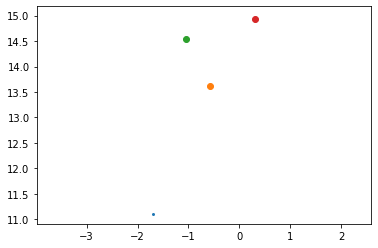

In [6]:
quickplot(sim)

In [7]:
sim.particles[0]

<rebound.particle.Particle object at 0x7f9802080950, m=1.0 x=-0.5750406965013769 y=13.625158939861556 z=0.0 vx=0.0015436593194370594 vy=0.000248225023891395 vz=0.0>

In [3]:
E0

-0.0008154272402872635

In [2]:
sim.calculate_energy()

-0.0024516365924350456

In [4]:
asteroidEccs[-1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00977469, 0.        , 0.65833077, 0.        , 0.        ,
       0.0064416 , 0.04107512, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00419709, 0.        , 0.        , 0.0170474 , 0.        ,
       0.        , 0.93294643, 0.        , 0.        , 0.28810865,
       0.05186572, 0.        , 0.00346148, 0.        , 0.00887923,
       0.        , 0.        , 0.78410993, 0.        , 0.01080975,
       0.        , 0.        , 0.        , 0.        , 0.00350519,
       0.6344439 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00508045, 0.        ,
       0.        , 0.0032816 , 0.        , 0.        , 0.        ,
       0.        , 0.82354522, 0.18097479, 0.        , 0.        ,
       0.        , 0.61340977, 0.        , 0.        , 0.     